In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import tensorflow as tf
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, top_k_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from machine_learning_utils import *
import cv2 as cv
import seaborn as sns

### Load data

In [2]:
train_folder = 'final dataset/train'
test_folder = 'final dataset/test'

### Load images in the right format for scikit-learn.

In [3]:
train_images, train_labels, class_names = load_images(train_folder, image_size=(224,224), gray=False)
images = train_images.astype(np.float32)

In [4]:
test_images, test_labels, class_names_test = load_images(test_folder, image_size=(224,224), gray=False)
test_images = test_images.astype(np.float32)

## Preprocessing the images

### Image normalization

In [5]:
images /= 255.0
test_images /= 255.0

### Remove noise from images using Gaussian Blur.

In [6]:
for i in range(len(images)):
    images[i] = cv.GaussianBlur(images[i], (5, 5), 0)

## **Classification using color histograms**

### Compute color histograms and flatten images

In [7]:
# Compute color histograms for training set
feature_vectors = []
for img in images:
    feature_vector = calculate_histograms(img, norm=True)
    feature_vector /= feature_vector.sum()  # Histogram normalization
    feature_vectors.append(feature_vector)
x_train = np.array(feature_vectors)  # Convert histogram to np array

In [8]:
# Compute color histograms for test set
feature_vectors = []
for img in test_images:
    feature_vector = calculate_histograms(img, norm=True)
    if feature_vector.sum()!=0:
        feature_vector /= feature_vector.sum()
    feature_vectors.append(feature_vector)
x_test = np.array(feature_vectors)

### XGBoost with Color Histograms

In [9]:
model = XGBClassifier(n_estimators = 200, learning_rate = 0.05, max_depth=6, objective="multi:softmax", reg_lambda = 5, reg_alpha = 0.5, random_state=42)
model.fit(x_train, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

### Train Error

In [10]:
y_pred_train = model.predict(x_train)
print(classification_report(train_labels, y_pred_train))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1200
           1       0.87      0.90      0.89      1200
           2       0.90      0.87      0.89      1448
           3       0.82      0.97      0.89      4258
           4       0.91      0.89      0.90      2431
           5       0.90      0.80      0.85      1200
           6       0.85      0.81      0.83      1320
           7       0.92      0.83      0.87      1532
           8       0.91      0.72      0.80      1581
           9       0.92      0.90      0.91      1200

    accuracy                           0.88     17370
   macro avg       0.89      0.86      0.87     17370
weighted avg       0.88      0.88      0.88     17370



### Test Error

In [11]:
y_pred = model.predict(x_test)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.33      0.43       300
           1       0.45      0.65      0.53       300
           2       0.66      0.43      0.52       362
           3       0.70      0.82      0.76      1065
           4       0.52      0.60      0.56       608
           5       0.39      0.36      0.37       300
           6       0.47      0.38      0.42       330
           7       0.53      0.48      0.50       383
           8       0.37      0.39      0.38       396
           9       0.59      0.54      0.56       300

    accuracy                           0.56      4344
   macro avg       0.53      0.50      0.50      4344
weighted avg       0.56      0.56      0.55      4344



### Confusion Matrix

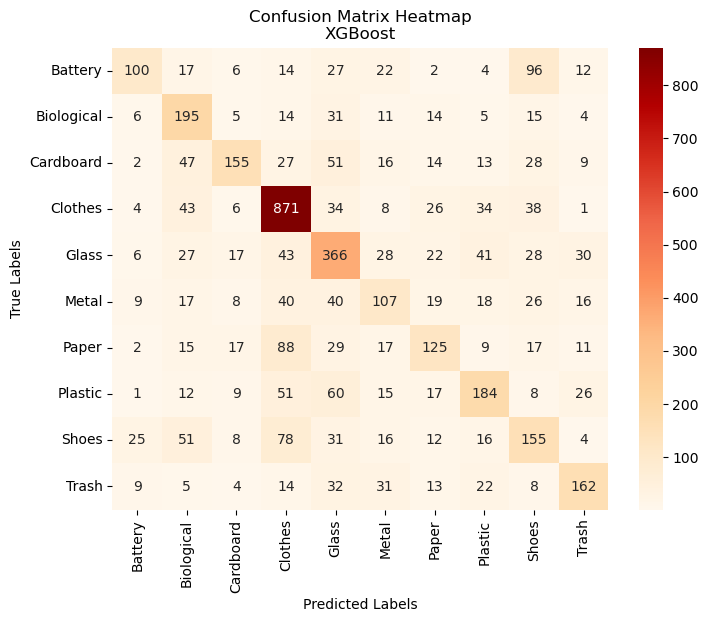

In [12]:
cm = confusion_matrix(test_labels, y_pred)

# Define class labels
labels = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic', 'Shoes', 'Trash']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap\nXGBoost')
plt.show()

In [14]:
xgboost_acc = accuracy_score(test_labels, y_pred)
xgboost_prec = precision_score(test_labels, y_pred, average='weighted')
xgboost_rec = recall_score(test_labels, y_pred, average='weighted')
xgboost_f1 = f1_score(test_labels, y_pred, average='weighted')

print(f"Accuracy: {xgboost_acc}")
print(f"Precision: {xgboost_prec}")
print(f"Recall: {xgboost_rec}")
print(f"F1 Score: {xgboost_f1}")

Accuracy: 0.5570902394106814
Precision: 0.5582808684376103
Recall: 0.5570902394106814
F1 Score: 0.549488400775989


## K-Nearest-Neighbors

In [ ]:
knn = KNeighborsClassifier()
grid_knn = {'n_neighbors':[i for i in range(50, 350, 50)],
            'weights':['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(knn, grid_knn, cv=5, scoring='accuracy', verbose=2)
if grid is not None:
    grid.fit(x_train, train_labels)

    print(f'Best score: {grid.best_score_}')
    for hp, value in grid.best_params_.items():
        print(f'{hp}:{value}\n')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\gabri\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Impossibile trovare il file specificato
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gabri\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\gabri\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gabri\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\gabri\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProce

[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.4s
[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.1s
[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.3s
[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.1s
[CV] END ..metric=euclidean, n_neighbors=50, weights=uniform; total time=   1.2s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   1.1s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   1.1s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   1.0s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   0.7s
[CV] END .metric=euclidean, n_neighbors=50, weights=distance; total time=   0.9s
[CV] END .metric=euclidean, n_neighbors=100, weights=uniform; total time=   1.2s
[CV] END .metric=euclidean, n_neighbors=100, weights=uniform; total time=   1.3s
[CV] END .metric=euclidean, 

In [15]:
knn = KNeighborsClassifier(n_neighbors=50, weights='distance', metric='manhattan')

knn.fit(x_train, train_labels)

KNeighborsClassifier(metric='manhattan', n_neighbors=50, weights='distance')

### Training error

In [17]:
y_pred_train = knn.predict(x_train)
print(classification_report(train_labels, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1200
           1       1.00      1.00      1.00      1200
           2       1.00      1.00      1.00      1448
           3       1.00      1.00      1.00      4258
           4       1.00      1.00      1.00      2431
           5       1.00      1.00      1.00      1200
           6       1.00      1.00      1.00      1320
           7       1.00      1.00      1.00      1532
           8       1.00      1.00      1.00      1581
           9       1.00      1.00      1.00      1200

    accuracy                           1.00     17370
   macro avg       1.00      1.00      1.00     17370
weighted avg       1.00      1.00      1.00     17370



### Test error

In [18]:
y_pred = knn.predict(x_test)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.27      0.38       300
           1       0.34      0.62      0.44       300
           2       0.57      0.37      0.45       362
           3       0.56      0.86      0.68      1065
           4       0.40      0.39      0.40       608
           5       0.38      0.14      0.20       300
           6       0.31      0.50      0.38       330
           7       0.60      0.21      0.31       383
           8       0.35      0.29      0.32       396
           9       0.67      0.28      0.40       300

    accuracy                           0.47      4344
   macro avg       0.48      0.39      0.40      4344
weighted avg       0.49      0.47      0.44      4344



### Confusion Matrix

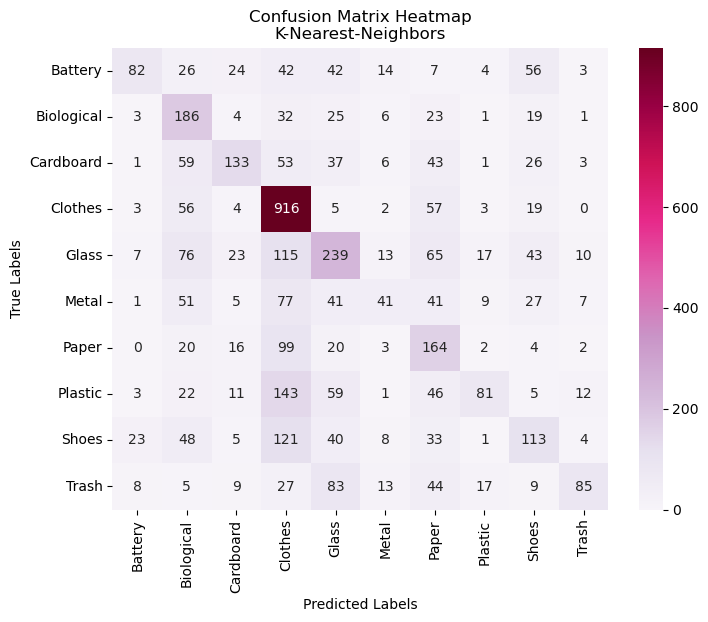

In [19]:
cm = confusion_matrix(test_labels, y_pred)

# Define class labels
labels = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic', 'Shoes', 'Trash']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap\nK-Nearest-Neighbors')
plt.show()

In [20]:
knn_acc = accuracy_score(test_labels, y_pred)
knn_prec = precision_score(test_labels, y_pred, average='weighted')
knn_rec = recall_score(test_labels, y_pred, average='weighted')
knn_f1 = f1_score(test_labels, y_pred, average='weighted')

print(f"Accuracy: {knn_acc}")
print(f"Precision: {knn_prec}")
print(f"Recall: {knn_rec}")
print(f"F1 Score: {knn_f1}")

Accuracy: 0.4696132596685083
Precision: 0.4898981574908684
Recall: 0.4696132596685083
F1 Score: 0.44337145376967935


## Decision Tree

In [ ]:
tree = DecisionTreeClassifier()

grid_tree = {'criterion':['gini', 'entropy', 'log_loss'],
             'splitter' : ['best', 'random'],
             'max_depth': [5, 10, 15]}

grid = GridSearchCV(tree, grid_tree, cv=5, scoring='accuracy', verbose=2)
if grid is not None:
    grid.fit(x_train, train_labels)

    print(f'Best score: {grid.best_score_}')
    for hp, value in grid.best_params_.items():
        print(f'{hp}:{value}\n')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   9.3s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   8.7s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   8.6s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   8.0s
[CV] END .........criterion=gini, max_depth=5, splitter=best; total time=   9.4s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.5s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.6s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.5s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.3s
[CV] END .......criterion=gini, max_depth=5, splitter=random; total time=   1.2s
[CV] END ........criterion=gini, max_depth=10, splitter=best; total time=  18.0s
[CV] END ........criterion=gini, max_depth=10, s

In [21]:
tree = DecisionTreeClassifier(criterion='log_loss', max_depth=10, splitter='best')
tree.fit(x_train, train_labels)

DecisionTreeClassifier(criterion='log_loss', max_depth=10)

### Train error

In [22]:
y_pred_train = tree.predict(x_train)
print(classification_report(train_labels, y_pred_train))

              precision    recall  f1-score   support

           0       0.61      0.68      0.64      1200
           1       0.72      0.63      0.67      1200
           2       0.71      0.52      0.60      1448
           3       0.59      0.88      0.71      4258
           4       0.65      0.57      0.60      2431
           5       0.63      0.32      0.42      1200
           6       0.31      0.49      0.38      1320
           7       0.68      0.46      0.54      1532
           8       0.64      0.28      0.39      1581
           9       0.79      0.67      0.72      1200

    accuracy                           0.60     17370
   macro avg       0.63      0.55      0.57     17370
weighted avg       0.63      0.60      0.59     17370



### Test error

In [23]:
y_pred = tree.predict(x_test)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.34      0.36       300
           1       0.37      0.48      0.42       300
           2       0.33      0.27      0.30       362
           3       0.54      0.63      0.58      1065
           4       0.33      0.36      0.34       608
           5       0.16      0.11      0.13       300
           6       0.21      0.32      0.25       330
           7       0.32      0.25      0.28       383
           8       0.30      0.18      0.22       396
           9       0.43      0.37      0.40       300

    accuracy                           0.38      4344
   macro avg       0.34      0.33      0.33      4344
weighted avg       0.37      0.38      0.37      4344



### Confusion Matrix

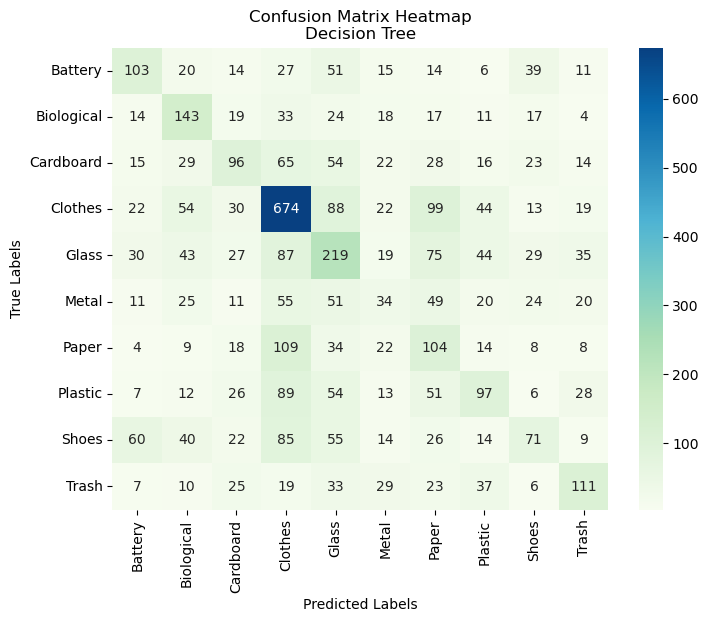

In [25]:
cm = confusion_matrix(test_labels, y_pred)

# Define class labels
labels = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic', 'Shoes', 'Trash']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap\nDecision Tree')
plt.show()

In [26]:
tree_acc = accuracy_score(test_labels, y_pred)
tree_prec = precision_score(test_labels, y_pred, average='weighted')
tree_rec = recall_score(test_labels, y_pred, average = 'weighted')
tree_f1 = f1_score(test_labels, y_pred, average='weighted')

print(f"Accuracy: {tree_acc}")
print(f"Precision: {tree_prec}")
print(f"Recall: {tree_rec}")
print(f"F1 Score: {tree_f1}")

Accuracy: 0.38029465930018413
Precision: 0.37144794139890996
Recall: 0.38029465930018413
F1 Score: 0.37115181183749646


## **Preprocessing with Autoencoders**

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_path = "/content/FDS-project/final dataset/train"
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_path = "/content/FDS-project/final dataset/test"
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_dataset.classes)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [9]:
print(f"Train set size: {len(train_loader.dataset)}")
print(f"Test set size: {len(test_loader.dataset)}")

Train set size: 17370
Test set size: 4344


In [10]:
input_size = 3 * 224 * 224
hidden_size = 64

autoencoder = SparseAutoencoder(input_size, hidden_size)

In [13]:
def extract_features_with_autoencoder(autoencoder, data_loader):
    autoencoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, label_batch in data_loader:
            images = images.view(images.size(0), -1)
            encoded, _ = autoencoder(images)
            features.append(encoded.numpy())
            labels.append(label_batch.numpy())
    return np.vstack(features), np.hstack(labels)

### Extract features from images

In [14]:
train_features, train_labels = extract_features_with_autoencoder(autoencoder, train_loader)
test_features, test_labels = extract_features_with_autoencoder(autoencoder, test_loader)

## Support Vector Machine

In [25]:
svm = SVC(kernel='rbf', verbose=True, tol = 1e-4, max_iter=1000, random_state=42)

svm.fit(train_features, train_labels)

[LibSVM]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(max_iter=1000, random_state=42, tol=0.0001, verbose=True)

### Train error

In [26]:
labels_pred_train = svm.predict(train_features)
print(classification_report(train_labels, labels_pred_train))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1200
           1       0.62      0.58      0.60      1200
           2       0.63      0.54      0.59      1448
           3       0.59      0.95      0.73      4258
           4       0.61      0.54      0.57      2431
           5       0.53      0.26      0.35      1200
           6       0.57      0.36      0.44      1320
           7       0.55      0.41      0.47      1532
           8       0.63      0.40      0.49      1581
           9       0.58      0.65      0.61      1200

    accuracy                           0.60     17370
   macro avg       0.60      0.53      0.55     17370
weighted avg       0.60      0.60      0.58     17370



### Test error

In [27]:
labels_pred = svm.predict(test_features)
print(classification_report(test_labels, labels_pred))

              precision    recall  f1-score   support

           0       0.55      0.49      0.52       300
           1       0.51      0.44      0.47       300
           2       0.53      0.45      0.49       362
           3       0.56      0.92      0.70      1065
           4       0.53      0.47      0.50       608
           5       0.37      0.17      0.23       300
           6       0.40      0.24      0.30       330
           7       0.51      0.36      0.42       383
           8       0.44      0.30      0.36       396
           9       0.57      0.62      0.60       300

    accuracy                           0.53      4344
   macro avg       0.50      0.45      0.46      4344
weighted avg       0.51      0.53      0.50      4344



### Confusion Matrix

In [1]:
cm = confusion_matrix(test_labels, labels_pred)

# Define class labels
labels = ['Battery', 'Biological', 'Cardboard', 'Clothes', 'Glass', 'Metal', 'Paper', 'Plastic', 'Shoes', 'Trash']

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap\nSupport Vector Machine')
plt.show()

NameError: name 'confusion_matrix' is not defined

In [28]:
svm_acc = accuracy_score(test_labels, labels_pred)
svm_prec = precision_score(test_labels, labels_pred, average='weighted')
svm_rec = recall_score(test_labels, labels_pred, average='weighted')
svm_f1 = f1_score(test_labels, labels_pred, average='weighted')

print(f"Accuracy: {svm_acc}")
print(f"Precision: {svm_prec}")
print(f"Recall: {svm_rec}")
print(f"F1 Score: {svm_f1}")

Accuracy: 0.5271639042357275
Precision: 0.5090452451830529
Recall: 0.5271639042357275
F1 Score: 0.4998551220499695
